In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 41.1 MB/s eta 0:00:00
--- 1. Carregando e Limpando Dados ---
drive/	sample_data/


/tmp/ipython-input-3489950743.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_final = pd.read_csv(caminho_arquivo, index_col=0, parse_dates=True)


Outlier do 'indice_ipca' corrigido (substituído pela mediana).

--- 2. Criando Features (Lags) ---
Features de Lag (lag_1, lag_2, lag_3) criadas.

--- 3. Dividindo Dados em Treino e Teste ---
44 meses para treino, 11 meses para teste.

--- 4. Treinando Modelo 1: SARIMA ---
Valor-p do ADF: 1.00. A série NÃO é estacionária (tem tendência).
Melhor modelo SARIMA encontrado:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   44
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -398.529
Date:                            Fri, 05 Dec 2025   AIC                            801.058
Time:                                    02:32:01   BIC                            803.926
Sample:                                         0   HQIC                           801.993
                                             - 44                                

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


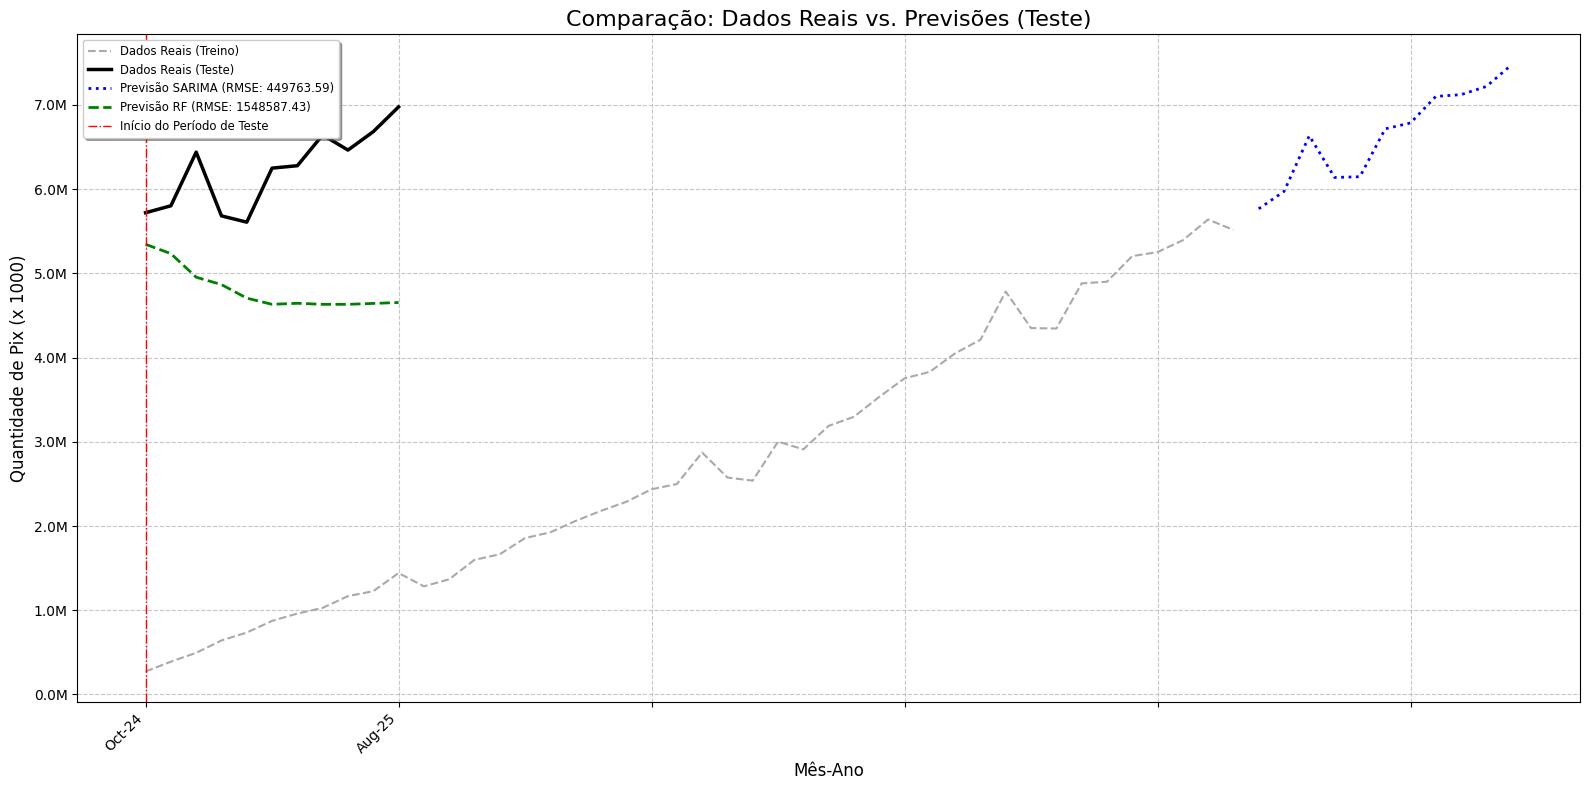


--- 7. Validando Resíduos do Modelo SARIMA ---


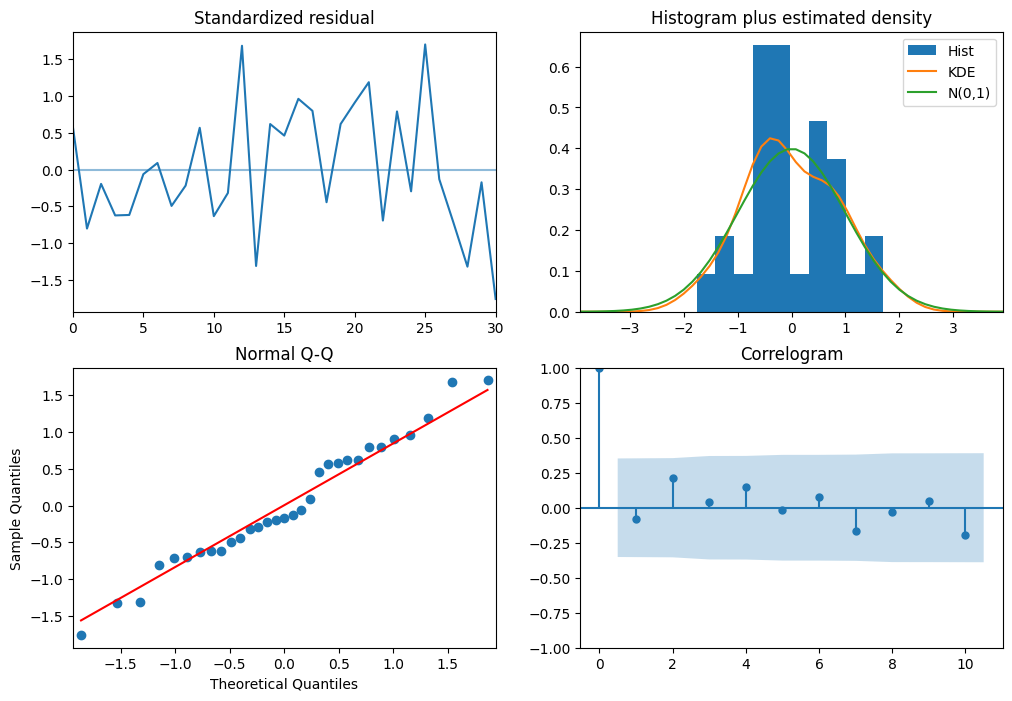


--- 8. Previsão Final para os Próximos 3 Meses ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Previsão da 'quantidadePix' para os próximos 3 meses:
55    6.728679e+06
56    6.947330e+06
57    7.015606e+06
dtype: float64


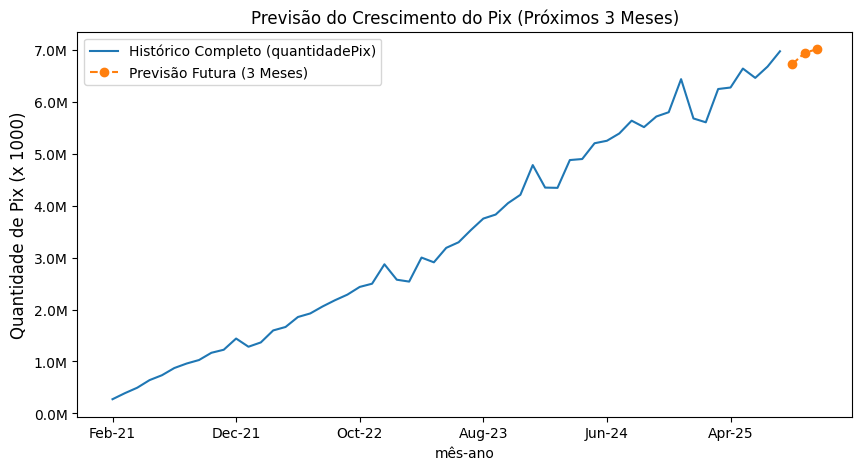

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

!pip install pmdarima
from pmdarima import auto_arima

print("--- 1. Carregando e Limpando Dados ---")

!ls -F


caminho_arquivo = r'/content/drive/MyDrive/A3 - Inteligência Artificial/Arquivos Notebook/COMPORTAMENTO_PIX-2020-2025[atualizada].csv'

try:
    df_final = pd.read_csv(caminho_arquivo, index_col=0, parse_dates=True)
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado em '{caminho_arquivo}'.")
    print("Por favor, verifique se o arquivo foi enviado corretamente para o ambiente Colab e se o caminho está correto.")
    raise

target = 'quantidadePix'

mediana_ipca = df_final['indice_ipca'].median()
df_final['indice_ipca'] = df_final['indice_ipca'].apply(lambda x: mediana_ipca if x < -1.0 else x)
print("Outlier do 'indice_ipca' corrigido (substituído pela mediana).")

print("\n--- 2. Criando Features (Lags) ---")
for i in range(1, 4):
    df_final[f'lag_{i}'] = df_final[target].shift(i)

df_final = df_final.dropna()
print("Features de Lag (lag_1, lag_2, lag_3) criadas.")

print("\n--- 3. Dividindo Dados em Treino e Teste ---")
y = df_final[target]
X = df_final.drop(columns=[target])

tamanho_treino = int(len(df_final) * 0.8)

X_treino, X_teste = X.iloc[:tamanho_treino], X.iloc[tamanho_treino:]
y_treino, y_teste = y.iloc[:tamanho_treino], y.iloc[tamanho_treino:]

print(f"{len(y_treino)} meses para treino, {len(y_teste)} meses para teste.")

print("\n--- 4. Treinando Modelo 1: SARIMA ---")
adf_result = adfuller(y_treino)
if adf_result[1] > 0.05:
    print(f"Valor-p do ADF: {adf_result[1]:.2f}. A série NÃO é estacionária (tem tendência).")
    d_param = 1
else:
    print(f"Valor-p do ADF: {adf_result[1]:.2f}. A série é estacionária.")
    d_param = 0

modelo_sarima = auto_arima(y_treino,
                           seasonal=True, m=12,
                           d=d_param,
                           suppress_warnings=True,
                           stepwise=True)

print("Melhor modelo SARIMA encontrado:")
print(modelo_sarima.summary())

print("\n--- 5. Treinando Modelo 2: Random Forest ---")
features_rf = ['taxa_selic', 'indice_ipca', 'lag_1', 'lag_2', 'lag_3', 'quantidadeTED']
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_treino[features_rf], y_treino)

print("Modelo Random Forest treinado.")

print("\nImportância das Features (Random Forest):\nPct: importance")
importances = pd.Series(modelo_rf.feature_importances_, index=features_rf).sort_values(ascending=False)
print(importances)


print("\n--- 6. Avaliando Modelos no Período de Teste ---")
previsoes_sarima = modelo_sarima.predict(n_periods=len(y_teste))
rmse_sarima = sqrt(mean_squared_error(y_teste, previsoes_sarima))
print(f"RMSE (SARIMA): {rmse_sarima:.2f}")

previsoes_rf = modelo_rf.predict(X_teste[features_rf])
rmse_rf = sqrt(mean_squared_error(y_teste, previsoes_rf))
print(f"RMSE (Random Forest): {rmse_rf:.2f}")

plt.figure(figsize=(16, 8))
plt.title("Comparação: Dados Reais vs. Previsões (Teste)", fontsize=16)
y_treino.plot(label='Dados Reais (Treino)', color='darkgray', linestyle='--', linewidth=1.5)
y_teste.plot(label='Dados Reais (Teste)', color='black', linewidth=2.5)
previsoes_sarima.plot(label=f'Previsão SARIMA (RMSE: {rmse_sarima:.2f})', color='blue', linestyle=':', linewidth=2)
previsoes_rf_series = pd.Series(previsoes_rf, index=y_teste.index)
previsoes_rf_series.plot(label=f'Previsão RF (RMSE: {rmse_rf:.2f})', color='green', linestyle='--', linewidth=2)

if not y_treino.empty:
    split_date = y_treino.index[-1]
    plt.axvline(x=split_date, color='red', linestyle='-.', linewidth=1, label='Início do Período de Teste')

plt.xlabel('Mês-Ano', fontsize=12)
plt.ylabel('Quantidade de Pix (x 1000)', fontsize=12)

ax = plt.gca()
formatter = FuncFormatter(lambda x, p: f'{x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left', fontsize='small', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- 7. Validando Resíduos do Modelo SARIMA ---")
modelo_sarima.plot_diagnostics(figsize=(12, 8))
plt.show()

print("\n--- 8. Previsão Final para os Próximos 3 Meses ---")
modelo_final_sarima = auto_arima(y,
                                 seasonal=True, m=12,
                                 d=d_param,
                                 suppress_warnings=True,
                                 stepwise=True)

previsao_futura = modelo_final_sarima.predict(n_periods=3)

print("Previsão da 'quantidadePix' para os próximos 3 meses:")
print(previsao_futura)

y_filtrado = y[y.index >= '2024-09-01']

plt.figure(figsize=(10, 5))
plt.title("Previsão do Crescimento do Pix (Próximos 3 Meses)")
y_filtrado.plot(label='Histórico Completo (quantidadePix)')
previsao_futura.plot(label='Previsão Futura (3 Meses)', linestyle='--', marker='o')

plt.ylabel('Quantidade de Pix (x 1000)', fontsize=12)

ax = plt.gca()
formatter = FuncFormatter(lambda x, p: f'{x/1e6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

plt.legend()
plt.show()